## Image Segmentation for Cells

In [25]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [34]:
# List all physical devices available to TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("TensorFlow is using the following GPU(s):")
    for device in physical_devices:
        print(device)
else:
    print("TensorFlow is not using any GPU.")

TensorFlow is not using any GPU.


In [26]:
# Setting random seed for reproducibility 
np.random.seed = 42

In [27]:
# Setting Image Dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [28]:
# Setting Dataset Paths
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [33]:
# Getting IDs of Images
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [11]:
# Establishing array of zeros that will be overwritten by image values after resizing
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [13]:
# Annoyingly complicated resize process. 
# Dataset contains images and their respected masks. However, for some reason, each cell in the images
# have their own separate mask files. We need to resize the training image, then overlay each cell mask
# in order to end with the image file and the single mask file

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Overriding np zero array
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [04:38<00:00,  2.41it/s]


In [14]:
# Same process for test images, but obviously no mask processing. 
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = [] 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 47.72it/s]

Done!


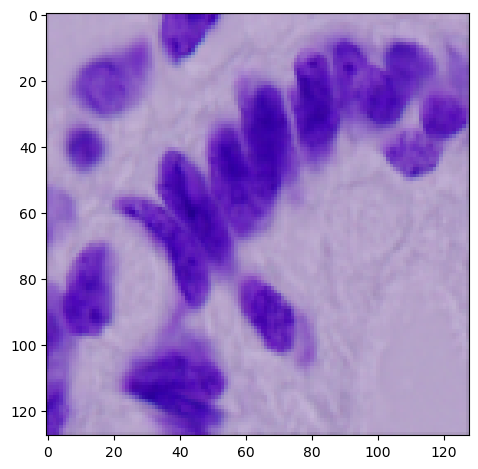

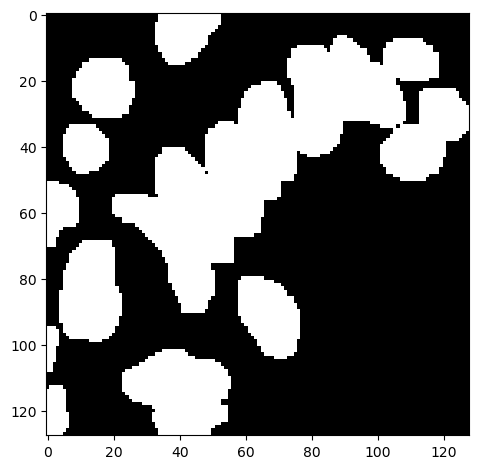

In [24]:
# Visualizing random training image and the new overlayed mask

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [16]:
#Build a U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [35]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model1.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 24s 585ms/step - loss: 0.5604 - accuracy: 0.7429 - val_loss: 0.3404 - val_accuracy: 0.7757
Epoch 2/25
38/38 [==============================] - 22s 587ms/step - loss: 0.3112 - accuracy: 0.8239 - val_loss: 0.2190 - val_accuracy: 0.9151
Epoch 3/25
38/38 [==============================] - 22s 568ms/step - loss: 0.1901 - accuracy: 0.9279 - val_loss: 0.1730 - val_accuracy: 0.9287
Epoch 4/25
38/38 [==============================] - 22s 575ms/step - loss: 0.1547 - accuracy: 0.9411 - val_loss: 0.1214 - val_accuracy: 0.9510
Epoch 5/25
38/38 [==============================] - 22s 578ms/step - loss: 0.1359 - accuracy: 0.9486 - val_loss: 0.1371 - val_accuracy: 0.9463
Epoch 6/25
38/38 [==============================] - 22s 570ms/step - loss: 0.1270 - accuracy: 0.9520 - val_loss: 0.1086 - val_accuracy: 0.9576
Epoch 7/25
38/38 [==============================] - 22s 574ms/step - loss: 0.1227 - accuracy: 0.9538 - val_loss: 0.1032 - val_accuracy: 0.9590

3/3 [==============================] - 0s 73ms/step


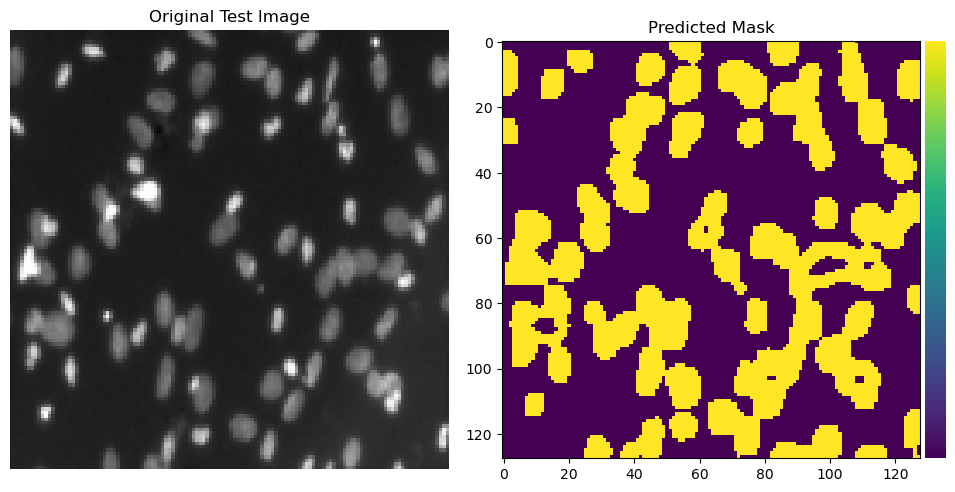

In [40]:
# Make predictions on the test set
# Apply threshold to predictions (binary segmentation)
# Visualize the prediction for a random test image
# Left: Original test image
# Right: Predicted mask

preds_test = model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(X_test) - 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Test Image")
imshow(X_test[ix])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
imshow(np.squeeze(preds_test_t[ix]))
plt.axis('off')

plt.show()